In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import os
import random
from tqdm import tqdm
from random import shuffle
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import keras.layers as kl
import numpy as np
import cv2

In [2]:
# Image size for our model.
MODEL_INPUT_IMAGE_SIZE = [ 96 , 96 ]

# Our Dataset
dataset = {"image": np.array([]),
          "age": np.array([])}

In [3]:
!pip3 install deeplake

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.6/430.6 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 60.5 MB/s eta 0:00:00
  Created wheel for deeplake: filename=deeplake-3.2.6-py3-none-any.whl size=525325 sha256=bde1aeb5f77ffa5f0424cb18c5f662fec4bdf88af5dec8bb27288f5a8a0bfbfd
  Stored in directory: /root/.cache/pip/wheels/ba/ca/67/a6cb2deac286b49e72cf480c358f2cdada9474938b0258915d
Successfully built deeplake


In [4]:
import deeplake
audience_dataset_path = 'hub://activeloop/adience'
audience_ds = deeplake.load(audience_dataset_path) # Returns a Deep Lake Dataset but does not download data locally

hub://activeloop/adience loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/adience


In [5]:
audience_ds.visualize()

HINT: Please forward the port - 37357 to your local machine, if you are running on the cloud.


In [6]:
print("Size of the Audience Dataset = ", audience_ds.tensors['ages'].numpy().size, '\n')
print("dict_keys(['images', 'labels']) : ", audience_ds.tensors.keys(), '\n')  
audience_ds.summary()

Size of the Audience Dataset =  19370 

dict_keys(['images', 'labels']) :  dict_keys(['ages', 'dx', 'dy', 'fiducial_score', 'fiducial_yaw_angle', 'genders', 'images', 'tilt_ang', 'x', 'y']) 

Dataset(path='hub://activeloop/adience', read_only=True, tensors=['ages', 'dx', 'dy', 'fiducial_score', 'fiducial_yaw_angle', 'genders', 'images', 'tilt_ang', 'x', 'y'])

       tensor           htype               shape              dtype  compression
      -------          -------             -------            -------  ------- 
        ages         class_label          (19370, 1)          uint32    None   
         dx             text              (19370, 1)            str     None   
         dy             text              (19370, 1)            str     None   
   fiducial_score       text              (19370, 1)            str     None   
 fiducial_yaw_angle     text              (19370, 1)            str     None   
      genders        class_label          (19370, 1)          uint32    Non

In [7]:
print("Genders: ", audience_ds.genders.info, '\n')
print(np.unique(audience_ds.genders.numpy()), '\n')

print("Ages: ", audience_ds.ages.info, '\n') # Should have 8 (0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60-) but it has 30 classes because of the missing ages between each 2 classes
print(np.unique(audience_ds.ages.numpy()), '\n')

Genders:  {'class_names': ['m', 'f', 'u', 'None']} 

[0 1 2 3] 

Ages:  {'class_names': ['(25, 32)', '(38, 43)', '(4, 6)', '(60, 100)', '(15, 20)', '(48, 53)', '(8, 12)', '(0, 2)', 'None', '(38, 48)', '35', '3', '55', '58', '22', '13', '45', '36', '23', '(38, 42)', '(8, 23)', '(27, 32)', '57', '56', '2', '29', '34', '42', '46', '32']} 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] 



(19370, None, None, 3)
(600, 601, 3)
<class 'deeplake.core.tensor.Tensor'>


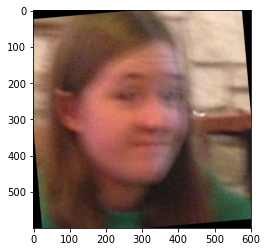

In [8]:
# Test if all is OKAY
# Get the first image in the dataset

image = audience_ds.images[0]
print(audience_ds.tensors['images'].shape)
print(image.shape)
print(type(image))
pyplot.imshow(np.array(image, dtype=int))
pyplot.show()

In [9]:
def get_random_age_from_its_class(index):
    age_index = {0: random.randint(25, 32),
           1: random.randint(38, 43),
           2: random.randint(4, 6),
           3: random.randint(60, 100),
           4: random.randint(15, 20),
           5: random.randint(48, 53), 
           6: random.randint(8, 12),
           7: random.randint(0, 2),
           8: random.randint(0, 100),
           9: random.randint(38, 48),
           10: 35,
           11: 3,
           12: 55,
           13: 58,
           14: 22,
           15: 13,
           16: 45,
           17: 36,
           18: 23,
           19: random.randint(38, 42),
           20: random.randint(8, 23),
           21: random.randint(27, 32),
           22: 57,
           23: 56,
           24: 2,
           25: 29,
           26: 34,
           27: 42,
           28: 46,
           29: 32}
    # Normalization
    return age_index[index]/116

In [10]:
def image_preprocessing(image):
    
    # Resizing
    image = tf.image.resize(image, MODEL_INPUT_IMAGE_SIZE)
    
    # Denosing
    image = cv2.fastNlMeansDenoisingColored(np.uint8(image),None,5,10,7,21)
    
    # Normalization
    image = image/255
    
    return image # Return image after resizing

In [11]:
def add_audience_dataset_to_our_dataset():
    
    for i in range(100): # audience_ds.images.shape[0] = 19370
    
        image = image_preprocessing(audience_ds.images[i])
        
        if i==0:
            dataset['image'] = np.array([image, ])
        else:
            dataset['image'] = np.append(dataset['image'], [image], axis=0)
            
        index = audience_ds.ages[i].numpy()[0]
        dataset['age'] = np.append(dataset['age'], get_random_age_from_its_class(index))

In [12]:
add_audience_dataset_to_our_dataset()

2023-02-08 00:41:10.737476: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/opt/conda/lib/python3.7/site-packages/deeplake/core/tensor.py:601: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  "Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead."


In [13]:
# # Test if all is OKAY
print("Images Shape = ", dataset['image'].shape)
print(dataset['image'][0].shape)

print("Ages Shape = ", dataset['age'].shape)
print(dataset['age'][0])

Images Shape =  (100, 96, 96, 3)
(96, 96, 3)
Ages Shape =  (100,)
0.07758620689655173
